#Prediction of Price of Flight ticket


###Importing  Required Libraries

In [46]:
import gc
import math
import PIL 
import pandas as pd
import numpy as np
import seaborn as sns
import datetime
import random
import warnings
import holidays
import datetime
import xgboost as xgb
from scipy import stats
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.linear_model import LinearRegression,Ridge,Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split , GridSearchCV,cross_val_score,cross_val_predict,cross_validate,RandomizedSearchCV
from sklearn.metrics import mean_absolute_error,explained_variance_score,max_error,r2_score,median_absolute_error,mean_squared_log_error
from sklearn.feature_selection import VarianceThreshold,SelectKBest,f_regression
from sklearn.preprocessing import MinMaxScaler,normalize,StandardScaler,RobustScaler
from sklearn.preprocessing import OneHotEncoder,LabelEncoder
from sklearn.decomposition import PCA
from sklearn.svm import SVR
!pip install mlxtend
import joblib
import sys
sys.modules['sklearn.externals.joblib'] = joblib
from mlxtend.feature_selection import SequentialFeatureSelector,ExhaustiveFeatureSelector

import warnings
warnings.filterwarnings('ignore')

In [47]:
from sklearn.metrics import mean_squared_error as mse

###Importing the data

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [49]:
data= pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Flight price prediction Datset.csv")
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


###Data Analysis


In [50]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [51]:
data.duplicated().sum()

220

In [52]:
data = data.drop_duplicates()

In [53]:
data_1 = data.copy()

In [54]:
const_feature = []
uniq_val_count = []
unique_cols = dict()
for col in list(data.columns):
    uniq_val_count.append(data[col].nunique())
    if(data[col].nunique()==1):
        const_feature.append(col)
    
# Removing the constant feature
data=data.drop(columns=const_feature)



##Preprocessing

###Treating the Dates

In [55]:
data.Date_of_Journey=data.Date_of_Journey.str.split('/')
data.Date_of_Journey

0        [24, 03, 2019]
1         [1, 05, 2019]
2         [9, 06, 2019]
3        [12, 05, 2019]
4        [01, 03, 2019]
              ...      
10678     [9, 04, 2019]
10679    [27, 04, 2019]
10680    [27, 04, 2019]
10681    [01, 03, 2019]
10682     [9, 05, 2019]
Name: Date_of_Journey, Length: 10463, dtype: object

In [56]:
data['Date']=data.Date_of_Journey.str[0]
data['Month']=data.Date_of_Journey.str[1]
data['Year']=data.Date_of_Journey.str[2]


In [57]:
data.Route=data.Route.str.split('→')
data.Route

0                      [BLR ,  DEL]
1        [CCU ,  IXR ,  BBI ,  BLR]
2        [DEL ,  LKO ,  BOM ,  COK]
3               [CCU ,  NAG ,  BLR]
4               [BLR ,  NAG ,  DEL]
                    ...            
10678                  [CCU ,  BLR]
10679                  [CCU ,  BLR]
10680                  [BLR ,  DEL]
10681                  [BLR ,  DEL]
10682    [DEL ,  GOI ,  BOM ,  COK]
Name: Route, Length: 10463, dtype: object

In [58]:
data['City1']=data.Route.str[0]
data['City2']=data.Route.str[1]
data['City3']=data.Route.str[2]
data['City4']=data.Route.str[3]
data['City5']=data.Route.str[4]
data['City6']=data.Route.str[5]

In [59]:
data.Dep_Time=data.Dep_Time.str.split(':')
data['Dep_Time_Hour']=data.Dep_Time.str[0]
data['Dep_Time_Min']=data.Dep_Time.str[1]

In [60]:
data.Arrival_Time=data.Arrival_Time.str.split(' ')
data['Arrival_date']=data.Arrival_Time.str[1]

data['Time_of_arrival']=data.Arrival_Time.str[0]
data['Time_of_arrival']=data.Time_of_arrival.str.split(':')

data['Arrival_Time_Hour']=data.Time_of_arrival.str[0]
data['Arrival_Time_Min']=data.Time_of_arrival.str[1]

In [61]:
data.Duration=data.Duration.str.split(' ')
data['Travel_hours']=data.Duration.str[0]
data['Travel_hours']=data['Travel_hours'].str.split('h')
data['Travel_hours']=data['Travel_hours'].str[0]
data.Travel_hours

0         2
1         7
2        19
3         5
4         4
         ..
10678     2
10679     2
10680     3
10681     2
10682     8
Name: Travel_hours, Length: 10463, dtype: object

In [62]:
data['Travel_mins']=data.Duration.str[1]
data.Travel_mins=data.Travel_mins.str.split('m')
data.Travel_mins=data.Travel_mins.str[0]
data.Travel_mins

0         50
1         25
2        NaN
3         25
4         45
        ... 
10678     30
10679     35
10680    NaN
10681     40
10682     20
Name: Travel_mins, Length: 10463, dtype: object

In [63]:
data.Total_Stops.unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

In [64]:
data.Total_Stops.replace('non-stop','0',inplace=True)
data.Total_Stops=data.Total_Stops.str.split(' ')
data.Total_Stops=data.Total_Stops.str[0]
data.Total_Stops

0        0
1        2
2        2
3        1
4        1
        ..
10678    0
10679    0
10680    0
10681    0
10682    2
Name: Total_Stops, Length: 10463, dtype: object

In [65]:
data.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,...,City5,City6,Dep_Time_Hour,Dep_Time_Min,Arrival_date,Time_of_arrival,Arrival_Time_Hour,Arrival_Time_Min,Travel_hours,Travel_mins
0,IndiGo,"[24, 03, 2019]",Banglore,New Delhi,"[BLR , DEL]","[22, 20]","[01:10, 22, Mar]","[2h, 50m]",0,No info,...,NaN,NaN,22,20,22,"[01, 10]",01,10,2,50
1,Air India,"[1, 05, 2019]",Kolkata,Banglore,"[CCU , IXR , BBI , BLR]","[05, 50]",[13:15],"[7h, 25m]",2,No info,...,NaN,NaN,05,50,NaN,"[13, 15]",13,15,7,25
2,Jet Airways,"[9, 06, 2019]",Delhi,Cochin,"[DEL , LKO , BOM , COK]","[09, 25]","[04:25, 10, Jun]",[19h],2,No info,...,NaN,NaN,09,25,10,"[04, 25]",04,25,19,NaN
3,IndiGo,"[12, 05, 2019]",Kolkata,Banglore,"[CCU , NAG , BLR]","[18, 05]",[23:30],"[5h, 25m]",1,No info,...,NaN,NaN,18,05,NaN,"[23, 30]",23,30,5,25
4,IndiGo,"[01, 03, 2019]",Banglore,New Delhi,"[BLR , NAG , DEL]","[16, 50]",[21:35],"[4h, 45m]",1,No info,...,NaN,NaN,16,50,NaN,"[21, 35]",21,35,4,45


In [66]:
#There are two values in Additional_Info with similar value, hence we merged both of them to a single value..
data.Additional_Info.replace('No info','No Info',inplace=True)

In [67]:
data.isnull().sum()

Airline                  0
Date_of_Journey          0
Source                   0
Destination              0
Route                    1
Dep_Time                 0
Arrival_Time             0
Duration                 0
Total_Stops              1
Additional_Info          0
Price                    0
Date                     0
Month                    0
Year                     0
City1                    1
City2                    1
City3                 3476
City4                 9101
City5                10419
City6                10462
Dep_Time_Hour            0
Dep_Time_Min             0
Arrival_date          6320
Time_of_arrival          0
Arrival_Time_Hour        0
Arrival_Time_Min         0
Travel_hours             0
Travel_mins           1006
dtype: int64

In [68]:
#Dropping all the unnecessary columns from which we created extra rows.
data=data.drop(columns=['Date_of_Journey','Route','Dep_Time','Arrival_Time','Duration','City4','City5','City6','Time_of_arrival'])
data.head()
#City4, City5,  City6 are also deleted as they contain many null values..

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Date,Month,Year,City1,City2,City3,Dep_Time_Hour,Dep_Time_Min,Arrival_date,Arrival_Time_Hour,Arrival_Time_Min,Travel_hours,Travel_mins
0,IndiGo,Banglore,New Delhi,0,No Info,3897,24,03,2019,BLR,DEL,NaN,22,20,22,01,10,2,50
1,Air India,Kolkata,Banglore,2,No Info,7662,1,05,2019,CCU,IXR,BBI,05,50,NaN,13,15,7,25
2,Jet Airways,Delhi,Cochin,2,No Info,13882,9,06,2019,DEL,LKO,BOM,09,25,10,04,25,19,NaN
3,IndiGo,Kolkata,Banglore,1,No Info,6218,12,05,2019,CCU,NAG,BLR,18,05,NaN,23,30,5,25
4,IndiGo,Banglore,New Delhi,1,No Info,13302,01,03,2019,BLR,NAG,DEL,16,50,NaN,21,35,4,45


###Working with Missing values

In [69]:
data.isnull().sum()

Airline                 0
Source                  0
Destination             0
Total_Stops             1
Additional_Info         0
Price                   0
Date                    0
Month                   0
Year                    0
City1                   1
City2                   1
City3                3476
Dep_Time_Hour           0
Dep_Time_Min            0
Arrival_date         6320
Arrival_Time_Hour       0
Arrival_Time_Min        0
Travel_hours            0
Travel_mins          1006
dtype: int64

In [70]:
data[data['Total_Stops'].isnull()]

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Date,Month,Year,City1,City2,City3,Dep_Time_Hour,Dep_Time_Min,Arrival_date,Arrival_Time_Hour,Arrival_Time_Min,Travel_hours,Travel_mins
9039,Air India,Delhi,Cochin,NaN,No Info,7480,6,05,2019,NaN,NaN,NaN,09,45,07,09,25,23,40


In [71]:
data['Total_Stops'].fillna('0',inplace=True)
data['City1'].fillna('DEL',inplace=True)
data['City2'].fillna('COK',inplace=True)

In [72]:
data['City3'].fillna('None',inplace=True)
data['Arrival_date'].fillna(data['Date'],inplace=True)
data['Travel_mins'].fillna('0',inplace=True)

In [73]:
data.isnull().sum()

Airline              0
Source               0
Destination          0
Total_Stops          0
Additional_Info      0
Price                0
Date                 0
Month                0
Year                 0
City1                0
City2                0
City3                0
Dep_Time_Hour        0
Dep_Time_Min         0
Arrival_date         0
Arrival_Time_Hour    0
Arrival_Time_Min     0
Travel_hours         0
Travel_mins          0
dtype: int64

Found a string '5m' in the column 'Travel_hours'  which is invalid, hence we are deleting that row of values which contains it.  

In [74]:
data[data['Travel_hours']=='5m']

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Date,Month,Year,City1,City2,City3,Dep_Time_Hour,Dep_Time_Min,Arrival_date,Arrival_Time_Hour,Arrival_Time_Min,Travel_hours,Travel_mins
6474,Air India,Mumbai,Hyderabad,2,No Info,17327,6,03,2019,BOM,GOI,PNQ,16,50,6,16,55,5m,0


In [75]:
data.drop(index=6474,inplace=True,axis=0)

##Visualising the Data

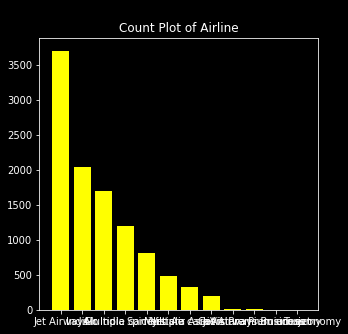

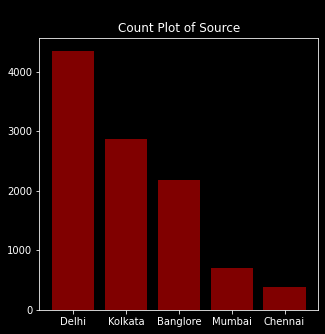

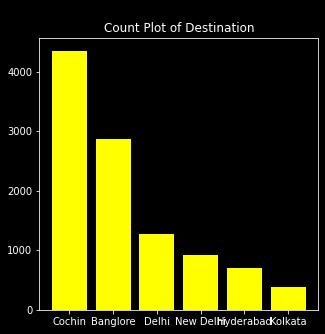

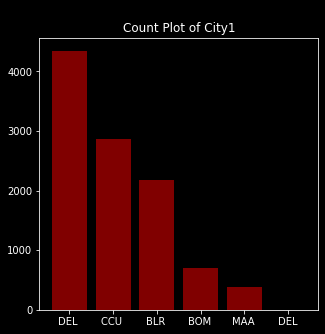

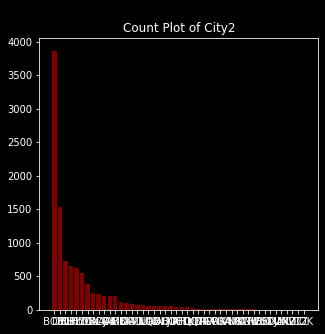

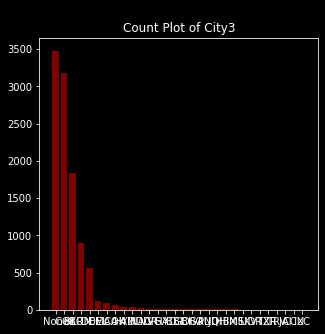

In [76]:
#Count Plots of Categorial Data
Categorial_Col=['Airline','Source','Destination','City1','City2','City3']

for col in Categorial_Col:
    plt.style.use('dark_background')
    plt.figure(figsize=(5,5))
    plt.bar(list(data[col].value_counts().index),list(data[col].value_counts()),color = random.sample(['maroon','yellow'],1))            
    plt.title('\nCount Plot of {}'.format(col))
    plt.show()

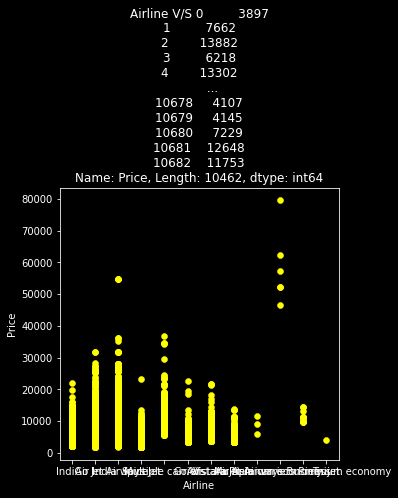

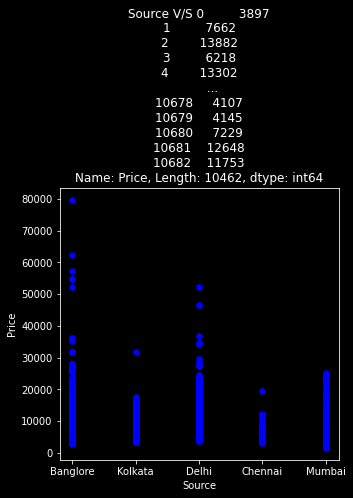

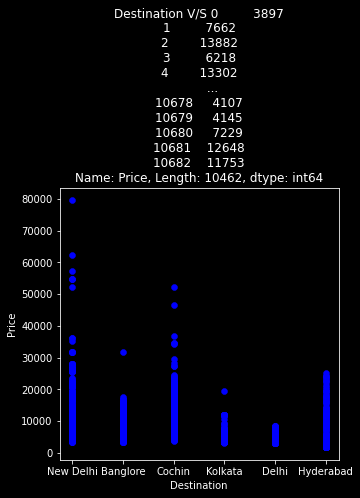

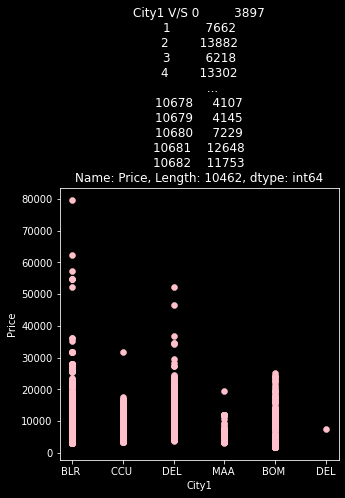

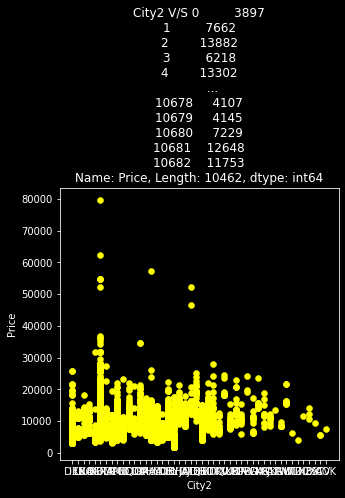

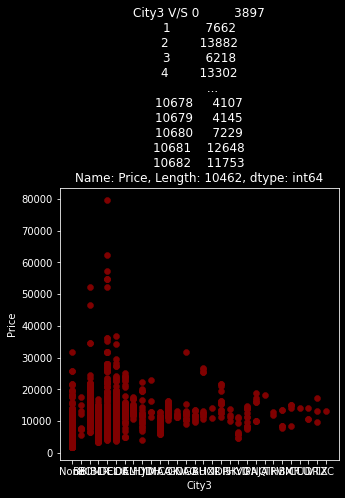

In [77]:
#Distribution of Price with Categorial Data
for col in Categorial_Col:
    plt.style.use('dark_background')
    plt.figure(figsize=(5,5))
    plt.scatter(data[col],data['Price'],color=random.sample(['yellow','maroon','blue','pink'],1),linewidth = .5)
    plt.title('{} V/S {}'.format(col,data.Price))
    plt.xlabel(col)
    plt.ylabel('Price')
    plt.show()

##Label Encoding the data

In [78]:
columns = ['Airline','Source','Destination','Total_Stops','Additional_Info','City1','City2','City3']

label_enc=LabelEncoder()


for col in range(len(columns)):
    label_enc.fit(data[columns[col]])
    data[columns[col]] = label_enc.transform(data[columns[col]])
    

In [79]:
data.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Price,Date,Month,Year,City1,City2,City3,Dep_Time_Hour,Dep_Time_Min,Arrival_date,Arrival_Time_Hour,Arrival_Time_Min,Travel_hours,Travel_mins
0,3,0,5,0,6,3897,24,03,2019,0,13,29,22,20,22,01,10,2,50
1,1,3,0,2,6,7662,1,05,2019,2,25,1,05,50,1,13,15,7,25
2,4,2,1,2,6,13882,9,06,2019,4,32,4,09,25,10,04,25,19,0
3,3,3,0,1,6,6218,12,05,2019,2,34,3,18,05,12,23,30,5,25
4,3,0,5,1,6,13302,01,03,2019,0,34,8,16,50,01,21,35,4,45


##Separating the Target and the Features

In [80]:
X=data.drop(columns=['Price'],axis=1)
Y=data['Price']

###Scaling the data

In [81]:
sc=StandardScaler()
x=sc.fit_transform(X)
X=pd.DataFrame(x,columns=X.columns)

In [82]:
X.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Date,Month,Year,City1,City2,City3,Dep_Time_Hour,Dep_Time_Min,Arrival_date,Arrival_Time_Hour,Arrival_Time_Min,Travel_hours,Travel_mins
0,-0.414916,-1.646950,2.404460,-1.214408,0.327634,1.244442,-1.462389,0.0,-1.500788,0.154665,1.378447,1.662695,-0.234105,0.964441,-1.806924,-0.888336,-0.958269,1.290878
1,-1.260756,0.882344,-0.971931,1.813509,0.327634,-1.471958,0.256368,0.0,-0.279091,1.685267,-1.092361,-1.305725,1.360432,-1.520864,-0.056455,-0.586531,-0.361469,-0.190406
2,0.008004,0.039246,-0.296652,1.813509,0.327634,-0.527123,1.115746,0.0,0.942605,2.578119,-0.827632,-0.607273,0.031651,-0.455733,-1.369307,0.017078,1.070852,-1.671691
3,-0.414916,0.882344,-0.971931,0.299550,0.327634,-0.172810,0.256368,0.0,-0.279091,2.833219,-0.915875,0.964244,-1.031374,-0.219037,1.402269,0.318882,-0.600189,-0.190406
4,-0.414916,-1.646950,2.404460,0.299550,0.327634,-1.471958,-1.462389,0.0,-1.500788,2.833219,-0.474659,0.615018,1.360432,-1.520864,1.110524,0.620687,-0.719549,0.994621


###Splitting the data into train and test data

In [83]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=.2,random_state=4)

In [84]:
X_train.head()

,Airline,Source,Destination,Total_Stops,Additional_Info,Date,Month,Year,City1,City2,City3,Dep_Time_Hour,Dep_Time_Min,Arrival_date,Arrival_Time_Hour,Arrival_Time_Min,Travel_hours,Travel_mins
8693,-0.414916,0.039246,-0.296652,0.299550,0.327634,0.535816,0.256368,0.0,0.942605,-0.610637,-0.651145,0.440405,-1.297130,0.609398,-1.806924,0.318882,-0.003388,0.105851
7361,-0.414916,-1.646950,2.404460,-1.214408,0.327634,1.244442,-1.462389,0.0,-1.500788,0.154665,1.378447,0.091179,-1.297130,1.201137,0.235289,1.526101,-0.958269,1.290878
7043,0.008004,0.039246,-0.296652,1.813509,0.327634,-1.471958,1.115746,0.0,0.942605,2.067918,-0.827632,1.138856,0.297407,-1.402516,-1.369307,0.017078,-0.242109,1.587135
5898,-1.260756,1.725442,1.053904,1.813509,0.327634,-0.881436,-1.462389,0.0,-0.889940,1.175066,-0.386416,-0.083434,1.094676,-0.810777,0.818779,0.017078,2.383814,0.698364
4079,-1.260756,0.039246,-0.296652,0.299550,0.327634,-0.527123,0.256368,0.0,0.942605,-0.738187,-0.651145,-0.607273,1.094676,-0.574081,1.402269,-1.491945,0.354692,-0.782920


##Training and Fitting with our models

###Decision Tree

In [85]:
dt=DecisionTreeRegressor()
dt.fit(X_train,Y_train)
pred_dt=dt.predict(X_test)
r2_score_dt=r2_score(Y_test,pred_dt)*100
print(r2_score_dt)
mean_squared_error_dt=mse(Y_test,pred_dt)
mse_dt=mean_squared_error_dt*(-1)
mse_dt

84.70543338523295


-3278256.6514572385

###Gradient Boosting Regressor

In [86]:
gbr=GradientBoostingRegressor()
gbr.fit(X_train,Y_train)
pred_gbr=gbr.predict(X_test)
r2_score_gbr=r2_score(Y_test,pred_gbr)*100
print(r2_score_gbr)
mean_squared_error_gbr=mse(Y_test,pred_gbr)
mse_gbr=mean_squared_error_gbr*(-1)
mse_gbr

84.87312142736431


-3242314.1855258285

###KNN

In [87]:
knn=KNeighborsRegressor()
knn.fit(X_train,Y_train)
pred_knn=knn.predict(X_test)
r2_score_knn=r2_score(Y_test,pred_knn)*100
print(r2_score_knn)
mean_squared_error_knn=mse(Y_test,pred_knn)
mse_knn=mean_squared_error_knn*(-1)
mse_knn

80.81627800651496


-4111863.1085714283

###Random Forest Regressor

In [88]:
rfr=RandomForestRegressor()
rfr.fit(X_train,Y_train)
pred_rfr=rfr.predict(X_test)
r2_score_rfr=r2_score(Y_test,pred_rfr)*100
print(r2_score_rfr)
mean_squared_error_rfr=mse(Y_test,pred_rfr)
mse_rfr=mean_squared_error_rfr*(-1)
mse_rfr

91.36898012431286


-1849983.6594920089

###Comparision between Models

In [89]:
Models=pd.DataFrame({'Models':['Decision Tree Regressor','Gradient Boosting Regressor','KNN','Random Forest Regressor'],
                     'Score':[r2_score_dt,r2_score_gbr,r2_score_knn,r2_score_rfr]
                    })
Models

,Models,Score
0,Decision Tree Regressor,84.705433
1,Gradient Boosting Regressor,84.873121
2,KNN,80.816278
3,Random Forest Regressor,91.368980


##Hyper Parameter Tuning

###Decision Tree Regressor

In [90]:
params_dt={"splitter":["best","random"],
            "max_depth" : [1,3,5,7,9,11,12],
           "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
           "min_weight_fraction_leaf":[0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9],
           "max_features":["auto","log2","sqrt",None],
           "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] }

grid_search_dt=GridSearchCV(dt,param_grid=params_dt,scoring='neg_mean_squared_error',cv=3,verbose=3)
grid_search_dt.fit(X_train,Y_train)
mse_dt_2=grid_search_dt.best_score_
print(mse_dt_2)
grid_search_dt.best_params_

Streaming output truncated to the last 5000 lines.
[CV 3/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.4, splitter=random;, score=-20818957.310 total time=   0.0s
[CV 1/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-21488269.163 total time=   0.0s
[CV 2/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-21407314.901 total time=   0.0s
[CV 3/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=best;, score=-21251984.927 total time=   0.0s
[CV 1/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8, min_weight_fraction_leaf=0.5, splitter=random;, score=-21488269.163 total time=   0.0s
[CV 2/3] END max_depth=12, max_features=None, max_leaf_nodes=None, min_samples_leaf=8

{'max_depth': 5,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'min_samples_leaf': 1,
 'min_weight_fraction_leaf': 0.1,
 'splitter': 'best'}

In [91]:
dt_2=DecisionTreeRegressor(max_depth=5,max_features='auto',max_leaf_nodes=None,min_samples_leaf=1,min_weight_fraction_leaf=0.1,splitter='best')
dt_2.fit(X_train,Y_train)
pred_dt_2=dt_2.predict(X_test)
r2_score_dt_2=r2_score(Y_test,pred_dt_2)*100
r2_score_dt_2

57.16912598381605

###Gradient Boosting

In [92]:
params_gbr = {'max_depth':range(5,16,2), 'min_samples_split':range(200,1001,200)}           
grid_search_gbr = GridSearchCV(estimator = GradientBoostingRegressor(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10),param_grid = params_gbr, scoring='neg_mean_squared_error',n_jobs=4, cv=5)
grid_search_gbr.fit(X_train, Y_train)
mse_gbr_2=grid_search_gbr.best_score_
print(mse_gbr_2)
grid_search_gbr.best_params_

-3060226.9986102744


{'max_depth': 15, 'min_samples_split': 200}

In [93]:
gbr_2=GradientBoostingRegressor(max_depth=15,min_samples_split=200)
gbr_2.fit(X_train,Y_train)
pred_gbr_2=gbr_2.predict(X_test)
r2_score_gbr_2=r2_score(Y_test,pred_gbr_2)*100
r2_score_gbr_2

92.16226591889748

###KNN

In [94]:
params_knn = { 'n_neighbors' : [i for i in range(3,20)],
               'weights' : ['uniform','distance'],
               'metric' : ['minkowski','euclidean','manhattan']}
grid_search_knn = GridSearchCV(knn, params_knn, verbose = 1,scoring='neg_mean_squared_error',cv=7, n_jobs = -1)
grid_search_knn.fit(X_train, Y_train)
mse_knn_2=grid_search_knn.best_score_
print(mse_knn_2)
grid_search_knn.best_params_

Fitting 7 folds for each of 102 candidates, totalling 714 fits
-4408550.980708084


{'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}

In [95]:
knn_2=KNeighborsRegressor(n_neighbors=5,weights='distance')
knn_2.fit(X_train,Y_train)
pred_knn_2=knn_2.predict(X_test)
r2_score_knn_2=r2_score(Y_test,pred_knn_2)*100
r2_score_knn_2

82.52013857807594

###Random Forest Regressor

In [96]:
params_rfr={'n_estimators':[10,30,50,70,100],'max_depth':[None,1,2,3],'max_samples':[50,100,250,500,1000],'min_samples_split':[2,4,10]}
grid_search_rfr=GridSearchCV(rfr,params_rfr,scoring='neg_mean_squared_error',cv=3)
grid_search_rfr.fit(X_train,Y_train)
mse_rfr_2=grid_search_rfr.best_score_
print(mse_rfr_2)
grid_search_rfr.best_params_

-4278532.415446077


{'max_depth': None,
 'max_samples': 1000,
 'min_samples_split': 4,
 'n_estimators': 100}

In [97]:
rfr_2=RandomForestRegressor(max_depth=None,min_samples_split=2,n_estimators=70)
rfr_2.fit(X_train,Y_train)
pred_rfr_2=rfr_2.predict(X_test)
r2_score_rfr_2=r2_score(Y_test,pred_rfr_2)*100
r2_score_rfr_2

91.74689891130858

##Comparing the models after Hyper Paramater Tuning

In [98]:
plot = ["before","after"]

Decision Tree

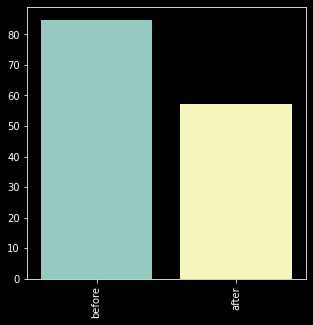

In [99]:
dt=[r2_score_dt,r2_score_dt_2]
fig=plt.figure(figsize=(5,5))
sns.barplot(x=plot,y=dt)
plt.xticks(rotation=90)
fig.show()

Gradient Boosting Regressor

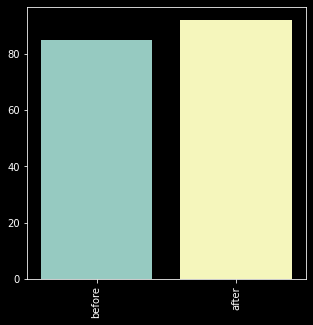

In [100]:
gb=[r2_score_gbr,r2_score_gbr_2]
fig=plt.figure(figsize=(5,5))
sns.barplot(x=plot,y=gb)
plt.xticks(rotation=90)
fig.show()

KNN

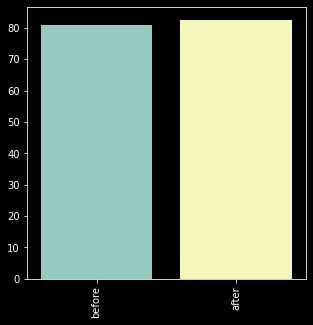

In [101]:
kn=[r2_score_knn,r2_score_knn_2]
fig=plt.figure(figsize=(5,5))
sns.barplot(x=plot,y=kn)
plt.xticks(rotation=90)
fig.show()

Random Forest Regressor

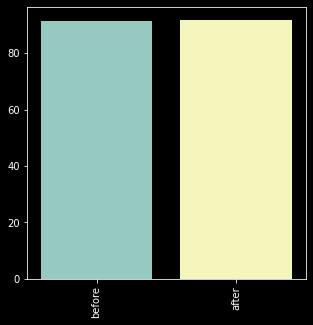

In [102]:
rf=[r2_score_rfr,r2_score_rfr_2]
fig=plt.figure(figsize=(5,5))
sns.barplot(x=plot,y=rf)
plt.xticks(rotation=90)
fig.show()

##Comparision

In [103]:
Models_2=pd.DataFrame({'Models':['Decision Tree Regressorr','Gradient Boosting Regressor','KNN','Random forest regressor'],
                     'Initial_Score':[r2_score_dt,r2_score_gbr,r2_score_knn,r2_score_rfr],
                     'Final_Score':[r2_score_dt_2,r2_score_gbr_2,r2_score_knn_2,r2_score_rfr_2]
                    })

Models_2

,Models,Initial_Score,Final_Score
0,Decision Tree Regressorr,84.705433,57.169126
1,Gradient Boosting Regressor,84.873121,92.162266
2,KNN,80.816278,82.520139
3,Random forest regressor,91.368980,91.746899


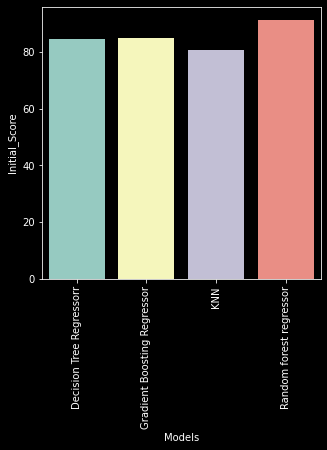

In [104]:
fig=plt.figure(figsize=(5,5))
sns.barplot(x=Models_2.Models,y=Models_2.Initial_Score)
plt.xticks(rotation=90)
fig.show()

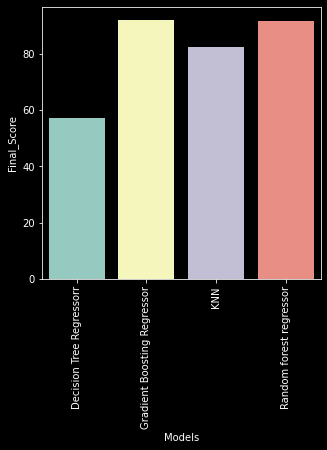

In [105]:
fig=plt.figure(figsize=(5,5))
sns.barplot(x=Models_2.Models,y=Models_2.Final_Score)
plt.xticks(rotation=90)
fig.show()

##After hypertuning all our model Gradient Boosting gave the best score, hence creating a dataframe of the predicted prices that came from this model.

In [107]:
model=GradientBoostingRegressor(learning_rate=0.1, n_estimators=60, max_features='sqrt', subsample=0.8, random_state=10,max_depth=15,min_samples_split=200)

In [108]:
import joblib
joblib.dump(model,'FlightPrice.obj')

['FlightPrice.obj']

In [109]:
model=joblib.load('FlightPrice.obj')
model.fit(X_train,Y_train)
Flight_Prices=model.predict(X_test)

predicted_values=pd.DataFrame({'Actual':Y_test,'Predicted':Flight_Prices})

In [110]:
Flight_Prices

array([3061.14306459, 6403.38994368, 4460.51082764, ..., 4942.95738607,
       4092.59226539, 4467.73941677])